In [1]:
import datetime, warnings, scipy 
import pandas as pd
import glob
import pytz
from time import time
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
from tqdm import tnrange, tqdm_notebook

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
def check_nulls(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.head(len(data.columns))
    return missing_data

In [3]:
data = pd.read_csv('LAS-JFK-ATL-utc.csv', 
              index_col=0, 
              parse_dates=[35, 36, 37, 38], 
              infer_datetime_format ="%Y-%m-%d %H:%M:%S")

In [4]:
df = data.copy()

In [5]:
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,UniqueCarrier,AirlineID,Carrier,TailNum,FlightNum,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,DepartureDelayGroups,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,Cancelled,CRSElapsedTime,ActualElapsedTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,SCH_START_DATETIME,SCH_END_DATETIME,ACT_START_DATETIME,ACT_END_DATETIME
0,2012,1,1,1,7,AA,19805,AA,N325AA,1,12478,JFK,12892,LAX,900,855,0,0,-1,1225,1142,0,0,-2,0,385,347.0,2475,10,0,0,0,0,0,2012-01-01 13:56:00,2012-01-01 20:21:00,2012-01-01 13:51:00,2012-01-01 19:38:00
1,2012,1,1,2,1,AA,19805,AA,N319AA,1,12478,JFK,12892,LAX,900,921,21,1,1,1225,1210,0,0,-1,0,385,349.0,2475,10,0,0,0,0,0,2012-01-02 13:56:00,2012-01-02 20:21:00,2012-01-02 14:17:00,2012-01-02 20:06:00
2,2012,1,1,3,2,AA,19805,AA,N323AA,1,12478,JFK,12892,LAX,900,931,31,1,2,1225,1224,0,0,-1,0,385,353.0,2475,10,0,0,0,0,0,2012-01-03 13:56:00,2012-01-03 20:21:00,2012-01-03 14:27:00,2012-01-03 20:20:00
3,2012,1,1,4,3,AA,19805,AA,N320AA,1,12478,JFK,12892,LAX,900,904,4,0,0,1225,1151,0,0,-2,0,385,347.0,2475,10,0,0,0,0,0,2012-01-04 13:56:00,2012-01-04 20:21:00,2012-01-04 14:00:00,2012-01-04 19:47:00
4,2012,1,1,5,4,AA,19805,AA,N338AA,1,12478,JFK,12892,LAX,900,858,0,0,-1,1225,1142,0,0,-2,0,385,344.0,2475,10,0,0,0,0,0,2012-01-05 13:56:00,2012-01-05 20:21:00,2012-01-05 13:54:00,2012-01-05 19:38:00


In [6]:
check_nulls(df).head()

,Total,Percent
ACT_END_DATETIME,0,0.0
FlightNum,0,0.0
DepDelayMinutes,0,0.0
DepTime,0,0.0
CRSDepTime,0,0.0


Проверим признаки погоды на валидность с другой стороны - не имеет смысла использовать признаки, которые имеют только одно уникальное значение, или которые являются строками, не относящимся непосредственно к рейсам или погодным условиям.

In [7]:
df.shape

(6115742, 38)

**Построить график карту**

Переводим все временные отметки в минуты, начиная с заданной начальной точки

In [8]:
df.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier',
       'AirlineID', 'Carrier', 'TailNum', 'FlightNum', 'OriginAirportID',
       'Origin', 'DestAirportID', 'Dest', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'CRSArrTime',
       'ArrTime', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups',
       'Cancelled', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance',
       'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay', 'SCH_START_DATETIME',
       'SCH_END_DATETIME', 'ACT_START_DATETIME', 'ACT_END_DATETIME'],
      dtype='object')

In [9]:
df.sort_values(by='SCH_START_DATETIME', inplace=True)

In [10]:
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,UniqueCarrier,AirlineID,Carrier,TailNum,FlightNum,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,DepartureDelayGroups,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,Cancelled,CRSElapsedTime,ActualElapsedTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,SCH_START_DATETIME,SCH_END_DATETIME,ACT_START_DATETIME,ACT_END_DATETIME
5644,2012,1,1,1,7,B6,20409,B6,N630JB,716,14843,SJU,12478,JFK,210,155,0,0,-1,510,442,0,0,-2,0,240,227.0,1598,7,0,0,0,0,0,2012-01-01 06:34:00,2012-01-01 10:34:00,2012-01-01 06:19:00,2012-01-01 10:06:00
12809,2012,1,1,1,7,DL,19790,DL,N727TW,1172,14869,SLC,12478,JFK,9,1,0,0,-1,633,604,0,0,-2,0,264,243.0,1990,8,0,0,0,0,0,2012-01-01 07:09:00,2012-01-01 11:33:00,2012-01-01 07:01:00,2012-01-01 11:04:00
5425,2012,1,1,1,7,B6,20409,B6,N536JB,98,11292,DEN,12478,JFK,50,106,16,1,1,626,628,2,0,0,0,216,202.0,1626,7,0,0,0,0,0,2012-01-01 07:50:00,2012-01-01 11:26:00,2012-01-01 08:06:00,2012-01-01 11:28:00
13304,2012,1,1,1,7,DL,19790,DL,N129DL,2324,14869,SLC,10397,ATL,55,51,0,0,-1,629,609,0,0,-2,0,214,198.0,1590,7,0,0,0,0,0,2012-01-01 07:55:00,2012-01-01 11:29:00,2012-01-01 07:51:00,2012-01-01 11:09:00
5637,2012,1,1,1,7,B6,20409,B6,N623JB,700,14843,SJU,12478,JFK,405,418,13,0,0,705,716,11,0,0,0,240,238.0,1598,7,0,0,0,0,0,2012-01-01 08:29:00,2012-01-01 12:29:00,2012-01-01 08:42:00,2012-01-01 12:40:00


In [11]:
start_date = datetime.datetime(2012, 1, 1, 0, 0, 0)
dates = ['SCH_START_DATETIME', 'SCH_END_DATETIME', 'ACT_START_DATETIME', 'ACT_END_DATETIME']
for date_ in tqdm_notebook(dates):
    df['SCH_START_DATETIME' + '_MIN'] = df.SCH_START_DATETIME.apply(lambda x: (x - start_date).total_seconds() // 60)
    df['SCH_END_DATETIME' + '_MIN'] = df.SCH_END_DATETIME.apply(lambda x: (x - start_date).total_seconds() // 60)
    df['ACT_START_DATETIME' + '_MIN'] = df.ACT_START_DATETIME.apply(lambda x: (x - start_date).total_seconds() // 60)
    df['ACT_END_DATETIME' + '_MIN'] = df.ACT_END_DATETIME.apply(lambda x: (x - start_date).total_seconds() // 60)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

In [12]:
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,UniqueCarrier,AirlineID,Carrier,TailNum,FlightNum,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,DepartureDelayGroups,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,Cancelled,CRSElapsedTime,ActualElapsedTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,SCH_START_DATETIME,SCH_END_DATETIME,ACT_START_DATETIME,ACT_END_DATETIME,SCH_START_DATETIME_MIN,SCH_END_DATETIME_MIN,ACT_START_DATETIME_MIN,ACT_END_DATETIME_MIN
5644,2012,1,1,1,7,B6,20409,B6,N630JB,716,14843,SJU,12478,JFK,210,155,0,0,-1,510,442,0,0,-2,0,240,227.0,1598,7,0,0,0,0,0,2012-01-01 06:34:00,2012-01-01 10:34:00,2012-01-01 06:19:00,2012-01-01 10:06:00,394.0,634.0,379.0,606.0
12809,2012,1,1,1,7,DL,19790,DL,N727TW,1172,14869,SLC,12478,JFK,9,1,0,0,-1,633,604,0,0,-2,0,264,243.0,1990,8,0,0,0,0,0,2012-01-01 07:09:00,2012-01-01 11:33:00,2012-01-01 07:01:00,2012-01-01 11:04:00,429.0,693.0,421.0,664.0
5425,2012,1,1,1,7,B6,20409,B6,N536JB,98,11292,DEN,12478,JFK,50,106,16,1,1,626,628,2,0,0,0,216,202.0,1626,7,0,0,0,0,0,2012-01-01 07:50:00,2012-01-01 11:26:00,2012-01-01 08:06:00,2012-01-01 11:28:00,470.0,686.0,486.0,688.0
13304,2012,1,1,1,7,DL,19790,DL,N129DL,2324,14869,SLC,10397,ATL,55,51,0,0,-1,629,609,0,0,-2,0,214,198.0,1590,7,0,0,0,0,0,2012-01-01 07:55:00,2012-01-01 11:29:00,2012-01-01 07:51:00,2012-01-01 11:09:00,475.0,689.0,471.0,669.0
5637,2012,1,1,1,7,B6,20409,B6,N623JB,700,14843,SJU,12478,JFK,405,418,13,0,0,705,716,11,0,0,0,240,238.0,1598,7,0,0,0,0,0,2012-01-01 08:29:00,2012-01-01 12:29:00,2012-01-01 08:42:00,2012-01-01 12:40:00,509.0,749.0,522.0,760.0


In [13]:
df.to_csv('LAS-JFK-ATL-utc.csv')

In [61]:
df = pd.read_csv('LAS-JFK-ATL-utc.csv', index_col=0, 
                 parse_dates=[35, 36, 37, 38], 
                 infer_datetime_format ="%Y-%m-%d %H:%M:%S")

In [62]:
df.columns

Index(['Unnamed: 0', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'UniqueCarrier', 'AirlineID', 'Carrier', 'TailNum', 'FlightNum',
       'OriginAirportID', 'Origin', 'DestAirportID', 'Dest', 'CRSDepTime',
       'DepTime', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups',
       'CRSArrTime', 'ArrTime', 'ArrDelayMinutes', 'ArrDel15',
       'ArrivalDelayGroups', 'Cancelled', 'CRSElapsedTime',
       'ActualElapsedTime', 'Distance', 'DistanceGroup', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'SCH_START_DATETIME', 'SCH_END_DATETIME', 'ACT_START_DATETIME',
       'ACT_END_DATETIME', 'SCH_START_DATETIME_MIN', 'SCH_END_DATETIME_MIN',
       'ACT_START_DATETIME_MIN', 'ACT_END_DATETIME_MIN'],
      dtype='object')

In [63]:
considered_airports = ['LAS', 'JFK', 'ATL']

In [64]:
unique_planes = list(set(df.TailNum))
dict_tail_sch_in_airport = dict()
dict_tail_fact_in_airport = dict()
sch_land = []
fact_land = []
for row in tqdm_notebook(df.itertuples(), 'last land time'):
    if row.Origin in considered_airports:
        if row.TailNum in dict_tail_sch_in_airport:
            sch_land.append(row.SCH_START_DATETIME_MIN - dict_tail_sch_in_airport[row.TailNum])
            dict_tail_sch_in_airport.pop(row.TailNum, None)
        else:
            sch_land.append(-1)
        if row.TailNum in dict_tail_fact_in_airport:
            fact_land.append(row.SCH_START_DATETIME_MIN - dict_tail_fact_in_airport[row.TailNum])
            dict_tail_fact_in_airport.pop(row.TailNum, None)
        else:
            fact_land.append(-1)
        if row.Dest in considered_airports:
            dict_tail_sch_in_airport[row.TailNum] = row.SCH_END_DATETIME_MIN
            dict_tail_fact_in_airport[row.TailNum] = row.ACT_END_DATETIME_MIN
    else:
        sch_land.append(-1)
        fact_land.append(-1)
        dict_tail_sch_in_airport[row.TailNum] = row.SCH_END_DATETIME_MIN
        dict_tail_fact_in_airport[row.TailNum] = row.ACT_END_DATETIME_MIN

HBox(children=(IntProgress(value=1, bar_style='info', description='last land time', max=1), HTML(value='')))

In [65]:
len(sch_land), len(fact_land), df.shape

(6115742, 6115742, (6115742, 43))

In [66]:
df['TIME_FROM_LAST_SCH_LAND'] = sch_land
df['TIME_FROM_LAST_FACT_LAND'] = fact_land

In [67]:
df[['TailNum', 'Origin', 'Dest', 'SCH_START_DATETIME',
       'SCH_END_DATETIME', 'ACT_START_DATETIME', 'ACT_END_DATETIME',
   'TIME_FROM_LAST_SCH_LAND', 'TIME_FROM_LAST_FACT_LAND']][df.TailNum == 'N630JB'].head(20)

,TailNum,Origin,Dest,SCH_START_DATETIME,SCH_END_DATETIME,ACT_START_DATETIME,ACT_END_DATETIME,TIME_FROM_LAST_SCH_LAND,TIME_FROM_LAST_FACT_LAND
0,N630JB,SJU,JFK,2012-01-01 06:34:00,2012-01-01 10:34:00,2012-01-01 06:19:00,2012-01-01 10:06:00,-1.0,-1.0
193,N630JB,JFK,SRQ,2012-01-01 12:57:00,2012-01-01 16:03:00,2012-01-01 12:50:00,2012-01-01 15:44:00,143.0,171.0
702,N630JB,SRQ,JFK,2012-01-01 16:43:00,2012-01-01 19:25:00,2012-01-01 16:30:00,2012-01-01 18:47:00,-1.0,-1.0
1371,N630JB,JFK,SJU,2012-01-01 20:26:00,2012-01-02 00:18:00,2012-01-01 20:19:00,2012-01-02 00:32:00,61.0,99.0
2229,N630JB,SJU,JFK,2012-01-02 01:31:00,2012-01-02 05:31:00,2012-01-02 01:44:00,2012-01-02 05:49:00,-1.0,-1.0
5106,N630JB,JFK,OAK,2012-01-02 23:26:00,2012-01-03 06:12:00,2012-01-02 23:37:00,2012-01-03 05:46:00,1075.0,1057.0
5896,N630JB,OAK,JFK,2012-01-03 07:02:00,2012-01-03 12:23:00,2012-01-03 06:49:00,2012-01-03 12:08:00,-1.0,-1.0
6395,N630JB,JFK,SJU,2012-01-03 13:36:00,2012-01-03 17:28:00,2012-01-03 13:32:00,2012-01-03 17:49:00,73.0,88.0
7586,N630JB,SJU,JFK,2012-01-03 19:16:00,2012-01-03 23:24:00,2012-01-03 19:12:00,2012-01-03 23:27:00,-1.0,-1.0
8554,N630JB,JFK,LAS,2012-01-03 23:46:00,2012-01-04 05:46:00,2012-01-04 00:01:00,2012-01-04 05:30:00,22.0,19.0


In [68]:
df[['TailNum', 'Origin', 'Dest', 'SCH_START_DATETIME',
       'SCH_END_DATETIME', 'ACT_START_DATETIME', 'ACT_END_DATETIME',
   'TIME_FROM_LAST_SCH_LAND', 'TIME_FROM_LAST_FACT_LAND']][df.TailNum == 'N367SW'][df.Year == 2012][df.Month == 1]

,TailNum,Origin,Dest,SCH_START_DATETIME,SCH_END_DATETIME,ACT_START_DATETIME,ACT_END_DATETIME,TIME_FROM_LAST_SCH_LAND,TIME_FROM_LAST_FACT_LAND
927,N367SW,PHX,LAS,2012-01-01 17:58:00,2012-01-01 19:08:00,2012-01-01 18:12:00,2012-01-01 19:07:00,-1.0,-1.0
1132,N367SW,LAS,BOI,2012-01-01 19:08:00,2012-01-01 21:03:00,2012-01-01 19:04:00,2012-01-01 20:47:00,0.0,1.0
1774,N367SW,BOI,LAS,2012-01-01 22:30:00,2012-01-02 00:10:00,2012-01-01 22:27:00,2012-01-02 00:10:00,-1.0,-1.0
2010,N367SW,LAS,HOU,2012-01-01 23:58:00,2012-01-02 02:53:00,2012-01-01 23:58:00,2012-01-02 02:55:00,-12.0,-12.0
31406,N367SW,RNO,LAS,2012-01-11 01:23:00,2012-01-11 02:43:00,2012-01-11 01:34:00,2012-01-11 02:45:00,-1.0,-1.0
31624,N367SW,LAS,HOU,2012-01-11 03:13:00,2012-01-11 06:03:00,2012-01-11 03:19:00,2012-01-11 05:57:00,30.0,28.0
56197,N367SW,LBB,LAS,2012-01-18 22:56:00,2012-01-19 01:16:00,2012-01-18 22:58:00,2012-01-19 01:02:00,-1.0,-1.0
56672,N367SW,LAS,SMF,2012-01-19 01:43:00,2012-01-19 03:13:00,2012-01-19 01:45:00,2012-01-19 03:03:00,27.0,41.0
87241,N367SW,ABQ,LAS,2012-01-28 20:35:00,2012-01-28 22:10:00,2012-01-28 20:31:00,2012-01-28 21:55:00,-1.0,-1.0
87632,N367SW,LAS,SFO,2012-01-28 22:38:00,2012-01-29 00:13:00,2012-01-28 22:34:00,2012-01-28 23:52:00,28.0,43.0


In [73]:
df = df[(df.TIME_FROM_LAST_SCH_LAND > -1) & (df.TIME_FROM_LAST_FACT_LAND > -1)]

In [74]:
df.shape

(2900144, 45)

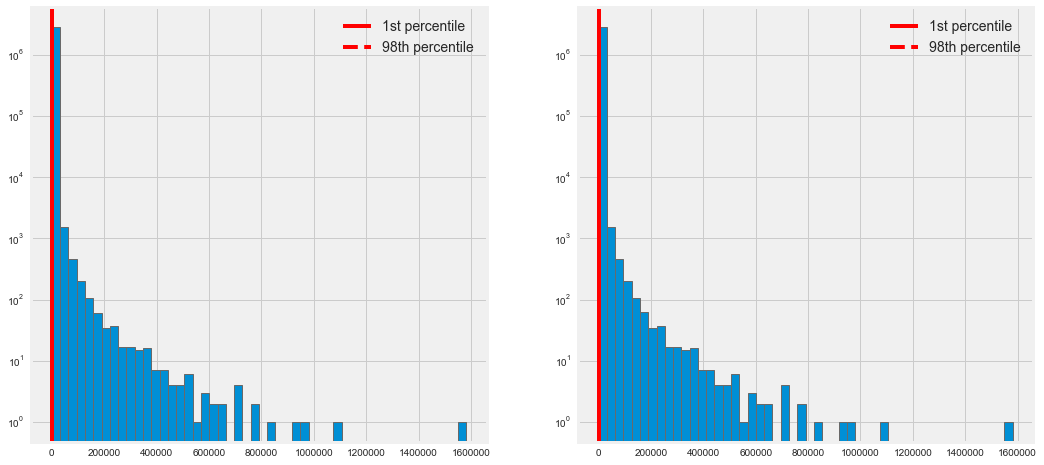

In [75]:
lowp = 0
highp = 98
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
df.TIME_FROM_LAST_SCH_LAND.hist(bins=50)
plt.yscale('log')
#plt.xscale('log')
plt.axvline(x=np.percentile(df.TIME_FROM_LAST_SCH_LAND, lowp), label='1st percentile', color='r')
plt.axvline(x=np.percentile(df.TIME_FROM_LAST_SCH_LAND, highp), label='98th percentile', color='r', ls='--')
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
df.TIME_FROM_LAST_FACT_LAND.hist(bins=50)
plt.yscale('log')
#plt.xscale('log')
plt.axvline(x=np.percentile(df.TIME_FROM_LAST_FACT_LAND, lowp), label='1st percentile', color='r')
plt.axvline(x=np.percentile(df.TIME_FROM_LAST_FACT_LAND, highp), label='98th percentile', color='r', ls='--')
plt.legend(fontsize=14)

In [76]:
np.percentile(df.TIME_FROM_LAST_SCH_LAND, lowp), np.percentile(df.TIME_FROM_LAST_SCH_LAND, highp)

(0.0, 1896.0)

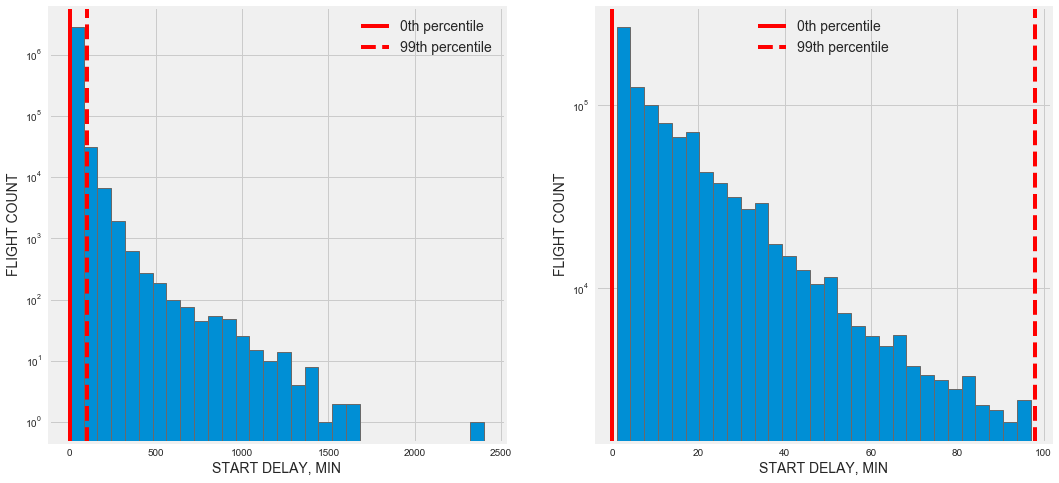

In [83]:
lowp = 0
highp = 99
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
df.DepDelayMinutes.hist(bins=30)
plt.xlabel('START DELAY, MIN', fontsize=14)
plt.ylabel('FLIGHT COUNT', fontsize=14)
plt.yscale('log')
plt.axvline(x=np.percentile(df.DepDelayMinutes, lowp), label=str(lowp) + 'th percentile', color='r')
plt.axvline(x=np.percentile(df.DepDelayMinutes, highp), label=str(highp) + 'th percentile', color='r', ls='--')
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
delays = df.DepDelayMinutes[(df.DepDelayMinutes > np.percentile(df.DepDelayMinutes, lowp)) & 
                        (df.DepDelayMinutes < np.percentile(df.DepDelayMinutes, highp))]
plt.hist(delays, bins=30)
plt.xlabel('START DELAY, MIN', fontsize=14)
plt.ylabel('FLIGHT COUNT', fontsize=14)
plt.yscale('log')
plt.axvline(x=np.percentile(df.DepDelayMinutes, lowp), label=str(lowp) + 'th percentile', color='r')
plt.axvline(x=np.percentile(df.DepDelayMinutes, highp), label=str(highp) + 'th percentile', color='r', ls='--')
plt.legend(fontsize=14)

In [84]:
np.percentile(df.DepDelayMinutes, lowp), np.percentile(df.DepDelayMinutes, highp)

(0.0, 98.0)

In [85]:
df['LATE_ARRIVAL_BEFORE'] = (df['TIME_FROM_LAST_FACT_LAND'] - df['TIME_FROM_LAST_SCH_LAND'])

In [87]:
df[['TIME_FROM_LAST_SCH_LAND', 'TIME_FROM_LAST_FACT_LAND', 'LATE_ARRIVAL_BEFORE']].describe()

,TIME_FROM_LAST_SCH_LAND,TIME_FROM_LAST_FACT_LAND,LATE_ARRIVAL_BEFORE
count,2.900144e+06,2.900144e+06,2.900144e+06
mean,3.379462e+02,3.429747e+02,5.028455e+00
std,3.825577e+03,3.826165e+03,8.544492e+01
min,0.000000e+00,0.000000e+00,-1.414000e+03
25%,4.500000e+01,4.800000e+01,-4.000000e+00
50%,5.800000e+01,6.500000e+01,6.000000e+00
75%,1.170000e+02,1.170000e+02,1.400000e+01
max,1.580915e+06,1.580897e+06,1.475000e+03


In [89]:
sum(df.SCH_START_DATETIME > df.SCH_END_DATETIME)

0

In [92]:
df['SCH_START_DATETIME'] = df['SCH_START_DATETIME'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

Год, месяц, день, день недели, время года (квартал) - уже есть, 
время суток:

In [93]:
df['FLIGHT_TIME_TO_MIDNIGHT'] = df.SCH_START_DATETIME.apply(lambda x: x.hour if x.hour <= 12 else (24 - x.hour))

In [98]:
df.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier',
       'AirlineID', 'Carrier', 'TailNum', 'FlightNum', 'OriginAirportID',
       'Origin', 'DestAirportID', 'Dest', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'CRSArrTime',
       'ArrTime', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups',
       'Cancelled', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance',
       'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay', 'SCH_START_DATETIME',
       'SCH_END_DATETIME', 'ACT_START_DATETIME', 'ACT_END_DATETIME',
       'SCH_START_DATETIME_MIN', 'SCH_END_DATETIME_MIN',
       'ACT_START_DATETIME_MIN', 'ACT_END_DATETIME_MIN',
       'TIME_FROM_LAST_SCH_LAND', 'TIME_FROM_LAST_FACT_LAND',
       'LATE_ARRIVAL_BEFORE', 'FLIGHT_TIME_TO_MIDNIGHT'],
      dtype='object')

In [101]:
df1 = pd.read_csv('LAS-JFK-ATL-utc-preprocessed.csv', index_col=0, parse_dates=[35, 36, 37, 38], 
                 infer_datetime_format ="%Y-%m-%d %H:%M:%S")
df1.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,UniqueCarrier,AirlineID,Carrier,TailNum,FlightNum,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,DepartureDelayGroups,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,Cancelled,CRSElapsedTime,ActualElapsedTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,SCH_START_DATETIME,SCH_END_DATETIME,ACT_START_DATETIME,ACT_END_DATETIME,SCH_START_DATETIME_MIN,SCH_END_DATETIME_MIN,ACT_START_DATETIME_MIN,ACT_END_DATETIME_MIN,TIME_FROM_LAST_SCH_LAND,TIME_FROM_LAST_FACT_LAND,LATE_ARRIVAL_BEFORE,FLIGHT_TIME_TO_MIDNIGHT
166,2012,1,1,1,7,MQ,20398,MQ,N815MQ,4406,12478,JFK,14492,RDU,745,739,0,0,-1,930,908,0,0,-2,0,105,89.0,427,2,0,0,0,0,0,2012-01-01 12:41:00,2012-01-01 14:26:00,2012-01-01 12:35:00,2012-01-01 14:04:00,761.0,866.0,755.0,844.0,35.0,53.0,18.0,12
188,2012,1,1,1,7,B6,20409,B6,N603JB,49,12478,JFK,14027,PBI,759,804,5,0,0,1058,1050,0,0,-1,0,179,166.0,1028,5,0,0,0,0,0,2012-01-01 12:55:00,2012-01-01 15:54:00,2012-01-01 13:00:00,2012-01-01 15:46:00,775.0,954.0,780.0,946.0,32.0,37.0,5.0,12
193,2012,1,1,1,7,B6,20409,B6,N630JB,341,12478,JFK,14986,SRQ,801,754,0,0,-1,1107,1048,0,0,-2,0,186,174.0,1041,5,0,0,0,0,0,2012-01-01 12:57:00,2012-01-01 16:03:00,2012-01-01 12:50:00,2012-01-01 15:44:00,777.0,963.0,770.0,944.0,143.0,171.0,28.0,12
198,2012,1,1,1,7,B6,20409,B6,N586JB,17,12478,JFK,11697,FLL,814,811,0,0,-1,1125,1108,0,0,-2,0,191,177.0,1069,5,0,0,0,0,0,2012-01-01 13:10:00,2012-01-01 16:21:00,2012-01-01 13:07:00,2012-01-01 16:04:00,790.0,981.0,787.0,964.0,59.0,56.0,-3.0,11
202,2012,1,1,1,7,MQ,20398,MQ,N816MQ,4416,12478,JFK,11278,DCA,815,812,0,0,-1,935,918,0,0,-2,0,80,66.0,213,1,0,0,0,0,0,2012-01-01 13:11:00,2012-01-01 14:31:00,2012-01-01 13:08:00,2012-01-01 14:14:00,791.0,871.0,788.0,854.0,35.0,57.0,22.0,11


Посчитаем количество бортов на момент вылета/прилёта по расписанию

Посмотрим на количество рейсов в месяц

In [22]:
df.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier',
       'AirlineID', 'Carrier', 'TailNum', 'FlightNum', 'OriginAirportID',
       'Origin', 'DestAirportID', 'Dest', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'CRSArrTime',
       'ArrTime', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups',
       'Cancelled', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance',
       'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay', 'SCH_START_DATETIME',
       'SCH_END_DATETIME', 'ACT_START_DATETIME', 'ACT_END_DATETIME',
       'SCH_START_DATETIME_MIN', 'SCH_END_DATETIME_MIN',
       'ACT_START_DATETIME_MIN', 'ACT_END_DATETIME_MIN',
       'TIME_FROM_LAST_SCH_LAND', 'TIME_FROM_LAST_FACT_LAND',
       'LATE_ARRIVAL_BEFORE', 'FLIGHT_TIME_TO_MIDNIGHT'],
      dtype='object')

In [23]:
gr = df[['Year', 'Month', 'ArrDel15']].groupby(['Year', 'Month']).count().reset_index()
gr.head()

,Year,Month,ArrDel15
0,2012,1,65491
1,2012,2,66688
2,2012,3,73279
3,2012,4,72087
4,2012,5,74201


In [24]:
gr['YEAR_MONTH'] = gr.apply(lambda x: datetime.datetime(x.Year, x.Month, 1), axis=1)

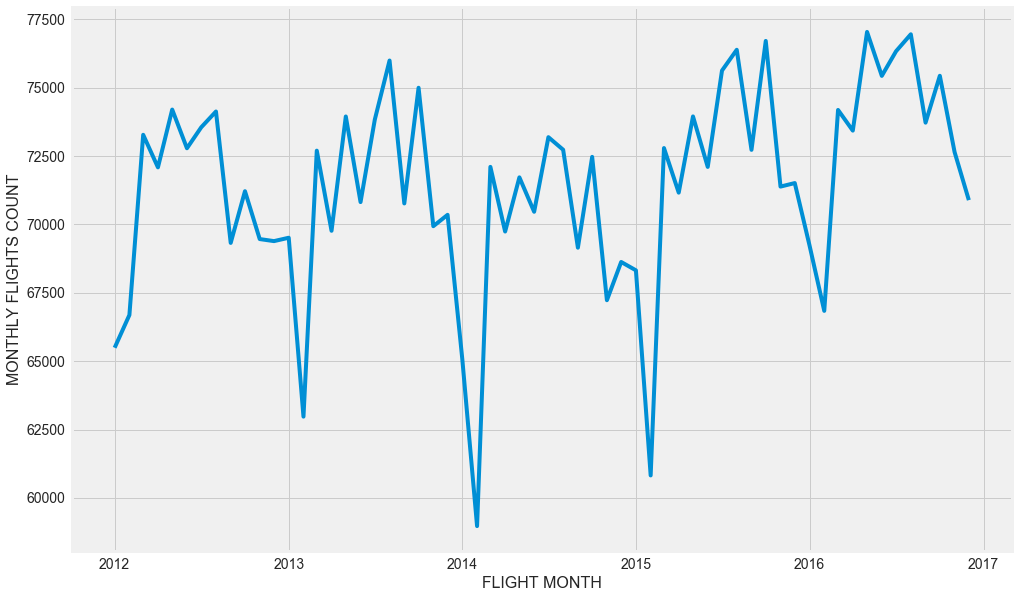

In [25]:
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr.YEAR_MONTH, gr.ArrDel15)
plt.xlabel('FLIGHT MONTH', fontsize=16)
plt.ylabel('MONTHLY FLIGHTS COUNT', fontsize=16)
plt.grid('on')

In [26]:
df.shape

(4284321, 46)

Посмотрим на среднюю задержку каждый месяц для 2016 года

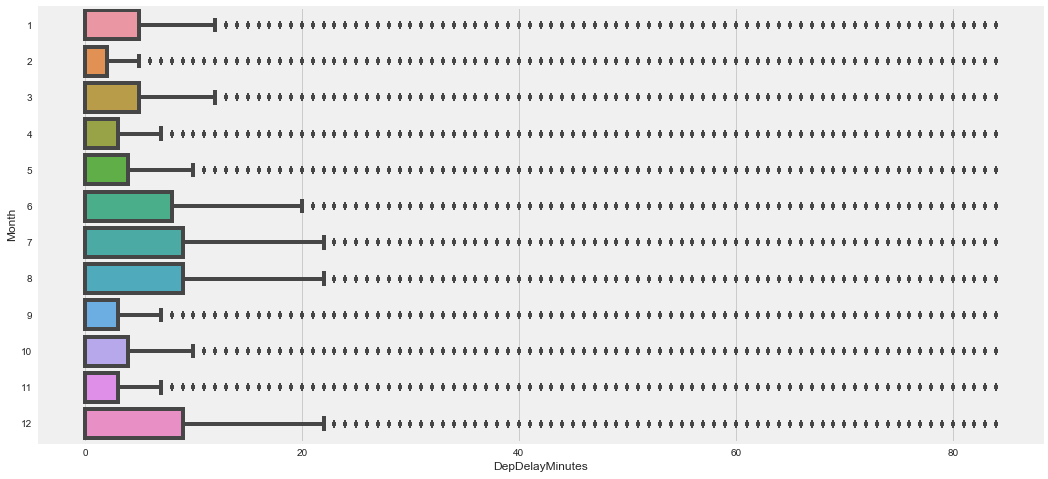

In [30]:
temp = df[df.Year == 2016]
plt.figure(figsize=(16, 8))
sns.boxplot(y="Month", x="DepDelayMinutes", data=temp, orient='h')

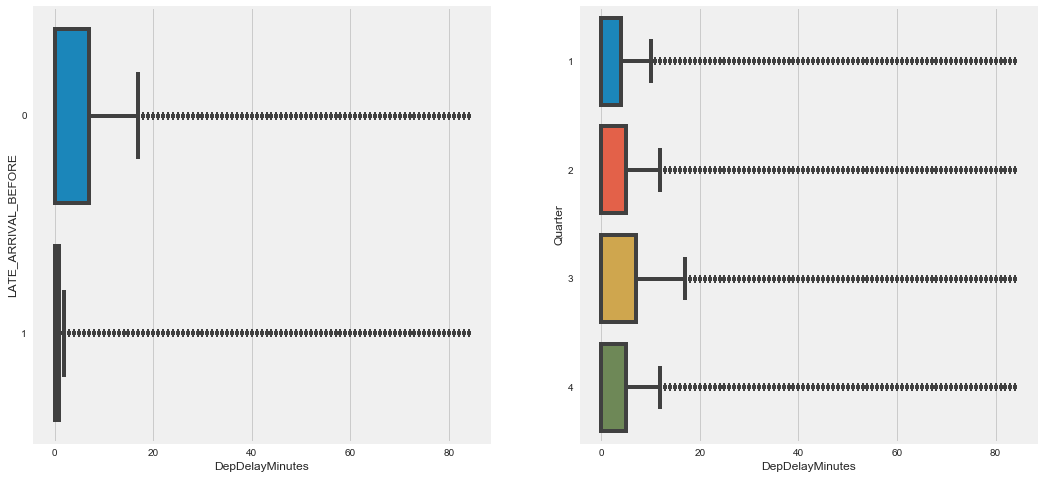

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(y="LATE_ARRIVAL_BEFORE", x="DepDelayMinutes", data=temp, orient='h')
plt.subplot(1, 2, 2)
sns.boxplot(y="Quarter", x="DepDelayMinutes",data=temp, orient='h')

In [31]:
def ratio_cumsum_attribute(df, arg_cols, datecol, bool_col, timedelta=datetime.timedelta(days=7), inplace=True):
#     if sort != '':
#         new_col_name = '_'.join(arg_cols)+'_'+ bool_col +'_ratio_sortby_' + sort
#         df.sort_values(by=sort, ascending=ascending, inplace=True)
#     else:
    new_col_name = '_'.join(arg_cols)+'_'+ bool_col + '_ratio'
    temp = df[arg_cols + [datecol, bool_col]]    
    dict_all = dict()
    newcol = list()
    arg_cols_ind = list(range(1, len(arg_cols)+1))
    datecol_ind = len(arg_cols) + 1
    bool_col_ind = datecol_ind + 1
    
    for row in temp.itertuples():
        key_list = list()
        for colind in arg_cols_ind:
            key_list.append(str(row[colind]))
        key = '_'.join(key_list)
        
        if key not in dict_all:
            val = 0
            dict_all[key] = {0: [], 1: []}
        else:
            for bi in [0, 1]:
                pop_keys = 0
                for i in range(len(dict_all[key][bi])):
                    if row[datecol_ind] - dict_all[key][bi][i] > timedelta:
                        pop_keys += 1
                    else:
                        break
                dict_all[key][bi] = dict_all[key][bi][pop_keys:]
            if (len(dict_all[key][0]) == 0) and (len(dict_all[key][1]) == 0):
                val = 0
            else:
                val = len(dict_all[key][1]) / (len(dict_all[key][1] + dict_all[key][0]))
                
        dict_all[key][row[bool_col_ind]].append(row[datecol_ind])
        newcol.append(val)
        
    if inplace:
        df[new_col_name] = newcol
        
    return dict_all, newcol

In [32]:
#df['PUB_DEPARTURE_ARRIVAL'] = df.apply(lambda x: x.PUB_DEPARTURE_AIRPORT_CODE + '-' + x.PUB_ARRIVAL_AIRPORT_CODE)

In [33]:
#df['PUB_DEPARTURE_AIRPORT_CODE'] = flight_leg_exp['PUB_DEPARTURE_AIRPORT_CODE']
#df['PUB_ARRIVAL_AIRPORT_CODE'] = flight_leg_exp['PUB_ARRIVAL_AIRPORT_CODE']

In [34]:
df.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier',
       'AirlineID', 'Carrier', 'TailNum', 'FlightNum', 'OriginAirportID',
       'Origin', 'DestAirportID', 'Dest', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'CRSArrTime',
       'ArrTime', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups',
       'Cancelled', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance',
       'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay', 'SCH_START_DATETIME',
       'SCH_END_DATETIME', 'ACT_START_DATETIME', 'ACT_END_DATETIME',
       'SCH_START_DATETIME_MIN', 'SCH_END_DATETIME_MIN',
       'ACT_START_DATETIME_MIN', 'ACT_END_DATETIME_MIN',
       'TIME_FROM_LAST_SCH_LAND', 'TIME_FROM_LAST_FACT_LAND',
       'LATE_ARRIVAL_BEFORE', 'FLIGHT_TIME_TO_MIDNIGHT'],
      dtype='object')

In [36]:
thresholds=[15]
from time import time
vals = {0: ['UniqueCarrier'],
        1: ['AirlineID'], 
        2: ['TailNum'],
        3: ['OriginAirportID', 'DestAirportID'],
        4: ['FlightNum'],
        5: ['CRSElapsedTime'],
        6: ['Distance'],
        7: ['LATE_ARRIVAL_BEFORE'],
        8: ['FLIGHT_TIME_TO_MIDNIGHT']
       }
start_total = time()
for threshold in tqdm_notebook(thresholds, 'threshold'):
    print('threshold: %d minutes' % threshold)
    for val in tqdm_notebook(vals.keys(), 'execute'):
        #start = time()
        print(vals[val])
        ratio_cumsum_attribute(df, vals[val], 'SCH_START_DATETIME', 'DepDel15')
        #print('time elapsed %3.2f min' % ((time() - start) / 60))
    #print()
print('total execution time %3.2f minutes' % ((time() - start_total) / 60))

HBox(children=(IntProgress(value=0, description='threshold', max=1), HTML(value='')))

threshold: 15 minutes


HBox(children=(IntProgress(value=0, description='execute', max=8), HTML(value='')))

['UniqueCarrier']
['AirlineID']
['TailNum']
['OriginAirportID', 'DestAirportID']
['CRSElapsedTime']
['Distance']
['LATE_ARRIVAL_BEFORE']
['FLIGHT_TIME_TO_MIDNIGHT']

total execution time 66.23 minutes


In [39]:
df.to_csv('usa-utc-ratio.zip')

In [41]:
df[['TailNum_DepDel15_ratio',
       #'DISPLAY_CODE_START_DELAY_GREATER_15_ratio',
       #'LEG_SEQUENCE_NUBMBER_START_DELAY_GREATER_15_ratio',
       #'PUB_DEPARTURE_AIRPORT_CODE_PUB_ARRIVAL_AIRPORT_CODE_START_DELAY_GREATER_15_ratio', 
    'TailNum', 'DepDelayMinutes', 'SCH_START_DATETIME'
       #'TAIL_NUMBER_END_DELAY_GREATER_15_ratio',
       #'DISPLAY_CODE_END_DELAY_GREATER_15_ratio',
       #'LEG_SEQUENCE_NUBMBER_END_DELAY_GREATER_15_ratio',
       #'PUB_DEPARTURE_AIRPORT_CODE_PUB_ARRIVAL_AIRPORT_CODE_END_DELAY_GREATER_15_ratio'
   ]][df['TailNum'] == 'N26226'].head(20)

,TailNum_DepDel15_ratio,TailNum,DepDelayMinutes,SCH_START_DATETIME
59307,0.000000,N26226,5,2012-01-01 13:11:00
59517,0.000000,N26226,14,2012-01-01 16:41:00
59538,0.000000,N26226,13,2012-01-01 20:25:00
59207,0.000000,N26226,20,2012-01-02 19:11:00
58227,0.250000,N26226,5,2012-01-05 14:26:00
58370,0.200000,N26226,23,2012-01-05 17:51:00
57481,0.666667,N26226,4,2012-01-08 23:47:00
57396,0.500000,N26226,0,2012-01-09 13:16:00
57317,0.250000,N26226,0,2012-01-10 04:32:00
57093,0.200000,N26226,2,2012-01-10 17:40:00


In [42]:
df.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier',
       'AirlineID', 'Carrier', 'TailNum', 'FlightNum', 'OriginAirportID',
       'Origin', 'DestAirportID', 'Dest', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'CRSArrTime',
       'ArrTime', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups',
       'Cancelled', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance',
       'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay', 'SCH_START_DATETIME',
       'SCH_END_DATETIME', 'ACT_START_DATETIME', 'ACT_END_DATETIME',
       'SCH_START_DATETIME_MIN', 'SCH_END_DATETIME_MIN',
       'ACT_START_DATETIME_MIN', 'ACT_END_DATETIME_MIN',
       'TIME_FROM_LAST_SCH_LAND', 'TIME_FROM_LAST_FACT_LAND',
       'LATE_ARRIVAL_BEFORE', 'FLIGHT_TIME_TO_MIDNIGHT',
       'UniqueCarrier_DepDel15_ratio', 'AirlineID_DepDel15_ratio',
       'TailNum_DepDel15_ratio',
       'OriginAirportID_D

In [80]:
df.replace({True: 1, False: 0}, inplace=True)
df.to_csv('usa_new_df_utc.csv')

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import plotly.plotly as py
import warnings
import xgboost
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [8]:
df = pd.read_csv('usa_new_df_utc.csv', index_col=0)

In [9]:
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,UniqueCarrier,AirlineID,Carrier,TailNum,FlightNum,...,FLIGHT_TIME_TO_MIDNIGHT,UniqueCarrier_START_DELAY_GREATER_15_ratio,AirlineID_START_DELAY_GREATER_15_ratio,TailNum_START_DELAY_GREATER_15_ratio,OriginAirportID_DestAirportID_START_DELAY_GREATER_15_ratio,CRSDepTime_CRSArrTime_START_DELAY_GREATER_15_ratio,CRSElapsedTime_START_DELAY_GREATER_15_ratio,Distance_START_DELAY_GREATER_15_ratio,LATE_ARRIVAL_BEFORE_START_DELAY_GREATER_15_ratio,FLIGHT_TIME_TO_MIDNIGHT_START_DELAY_GREATER_15_ratio
59307,2012,1,1,1,7,UA,19977,UA,N26226,1006,...,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4558,2012,1,1,1,7,AA,19805,AA,N5EHAA,1047,...,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59570,2012,1,1,1,7,US,20355,US,N632AW,29,...,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59792,2012,1,1,1,7,US,20355,US,N189UW,1525,...,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59630,2012,1,1,1,7,US,20355,US,N547UW,319,...,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier',
       'AirlineID', 'Carrier', 'TailNum', 'FlightNum', 'OriginAirportID',
       'Origin', 'DestAirportID', 'Dest', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'CRSArrTime',
       'ArrTime', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups',
       'Cancelled', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance',
       'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay', 'SCH_START_DATETIME',
       'SCH_END_DATETIME', 'ACT_START_DATETIME', 'ACT_END_DATETIME',
       'TIME_FROM_LAST_SCH_LAND', 'TIME_FROM_LAST_FACT_LAND', 'START_DELAY',
       'LATE_ARRIVAL_BEFORE', 'START_DELAY_GREATER_15',
       'FLIGHT_TIME_TO_MIDNIGHT', 'UniqueCarrier_START_DELAY_GREATER_15_ratio',
       'AirlineID_START_DELAY_GREATER_15_ratio',
       'TailNum_START_DELAY_GREATER_15_ratio',
       'OriginAirportID_DestAirportID_START_DELAY

In [12]:
df1 = df.copy()
df1.drop(['UniqueCarrier', 'Carrier',
       'Origin', 'Dest', 'CRSDepTime', 'DepTime',
       'DepartureDelayGroups', 'CRSArrTime',
       'ArrTime', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups',
       'Cancelled', 'ActualElapsedTime', 
       'SCH_START_DATETIME',
       'SCH_END_DATETIME', 'ACT_START_DATETIME', 'ACT_END_DATETIME',
       #3'SCH_START_DATETIME_MIN', 'SCH_END_DATETIME_MIN',
       #'ACT_START_DATETIME_MIN', 'ACT_END_DATETIME_MIN',
       'DepDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay', 'TailNum'], axis=1, inplace=True)

In [13]:
df1.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'AirlineID',
       'FlightNum', 'OriginAirportID', 'DestAirportID', 'DepDel15',
       'CRSElapsedTime', 'Distance', 'DistanceGroup',
       'TIME_FROM_LAST_SCH_LAND', 'TIME_FROM_LAST_FACT_LAND', 'START_DELAY',
       'LATE_ARRIVAL_BEFORE', 'START_DELAY_GREATER_15',
       'FLIGHT_TIME_TO_MIDNIGHT', 'UniqueCarrier_START_DELAY_GREATER_15_ratio',
       'AirlineID_START_DELAY_GREATER_15_ratio',
       'TailNum_START_DELAY_GREATER_15_ratio',
       'OriginAirportID_DestAirportID_START_DELAY_GREATER_15_ratio',
       'CRSDepTime_CRSArrTime_START_DELAY_GREATER_15_ratio',
       'CRSElapsedTime_START_DELAY_GREATER_15_ratio',
       'Distance_START_DELAY_GREATER_15_ratio',
       'LATE_ARRIVAL_BEFORE_START_DELAY_GREATER_15_ratio',
       'FLIGHT_TIME_TO_MIDNIGHT_START_DELAY_GREATER_15_ratio'],
      dtype='object')

In [14]:
def train_test_split(df, targetcol, train_split=0.8):
    df1 = df.copy().reset_index()
    df1.drop(labels='index', axis=1, inplace=True)
    #print(df.shape)
    #print(df1.shape)
    target = df1[targetcol]
    #print(target.shape)
    df1.drop(labels=targetcol, axis=1, inplace=True)
    
    train_size = int(df1.shape[0] * 0.8)
    x_train = df1.loc[:train_size, :]
    y_train = target[:train_size+1]
    x_test = df1.loc[train_size:, :]
    y_test = target[train_size:]
    
    return x_train, y_train, x_test, y_test, x_train.columns

In [15]:
X_train, y_train, X_test, y_test, _ = train_test_split(df1, 'DepDel15')
X_train.shape

(2062017, 27)

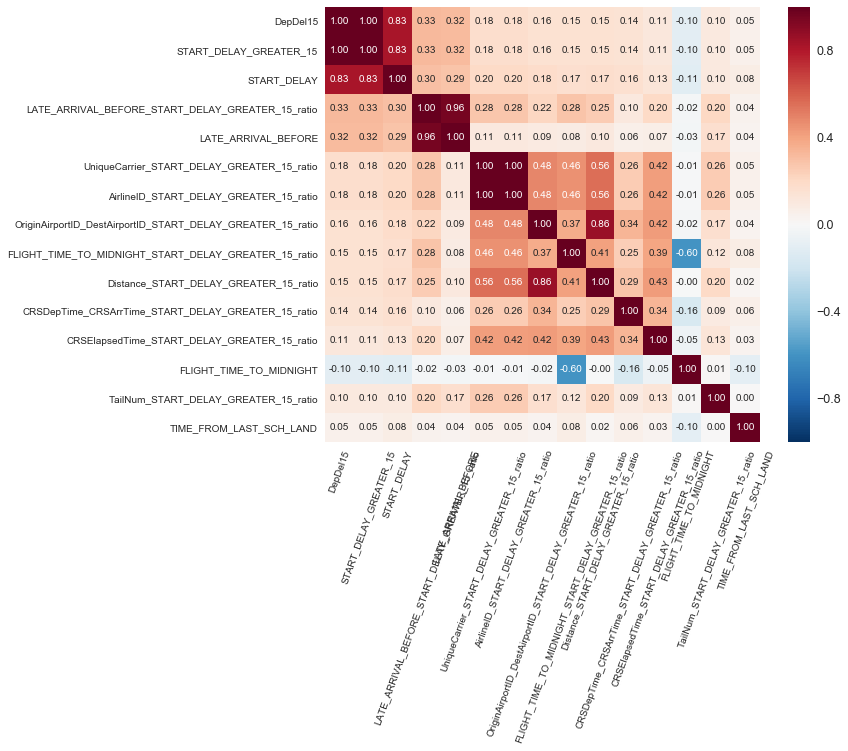

In [16]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df1.corr()
cols = corr.apply(lambda s: s.abs()).nlargest(15, 'DepDel15').index
cm = np.corrcoef(df1[cols].values.T)
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.xticks(rotation=70)
plt.show()

In [17]:
y_train.value_counts()

0    1678124
1     383893
Name: DepDel15, dtype: int64

In [18]:
y_test.value_counts()

0    427428
1     88077
Name: DepDel15, dtype: int64

In [19]:
def all_classifier(df, target_col, n_components=15, to_scale=False, to_select=False, clf=None, train_split=0.8):
    x_train, y_train, x_test, y_test, _ = train_test_split(df, target_col, train_split=train_split)
    
    #scale data
    if to_scale:
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
    
    # choose components
    if to_select:
        pca=PCA(n_components=n_components)
        pca.fit(x_train)
        x_train = pca.transform(x_train)
        x_test = pca.transform(x_test)
    
    # classification
    start = time()
    clf.fit(x_train, y_train)
    print('classifier training time: %3.2f minutes' % ((time() - start) / 60))
    y_pred = clf.predict(x_test)
    
    # metrics
    print('f1 score: %1.3f' % f1_score(y_test, y_pred))
    print('confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    

#### Random Forest predictor

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [4]:
from time import time
est = RandomForestClassifier(n_estimators = 100, 
                             max_depth = 6,
                             n_jobs=-1, 
                             class_weight='balanced')
start = time()
est.fit(X_train, y_train)
print('classifier training time: %3.2f minutes' % ((time() - start) / 60))

NameError: name 'X_train' is not defined

In [81]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score
y_pred = est.predict(X_test)

print('f1 score: %2.3f' % f1_score(y_test, y_pred))
print('accuracy score: %2.3f' % accuracy_score(y_test, y_pred))
print('recall score: %2.3f' % recall_score(y_test, y_pred, average='binary'))

f1 score: 0.387
accuracy score: 0.730
recall score: 0.568


In [77]:
confusion_matrix(y_test, y_pred)

array([[556782, 171461],
       [ 60464,  68158]], dtype=int64)

In [84]:
df1_delays = df.DepDelayMinutes
train_size = int(df1.shape[0] * 0.8)
y_delays = df1_delays[train_size:]

In [85]:
t = (y_test == y_pred)
f = (y_test != y_pred)

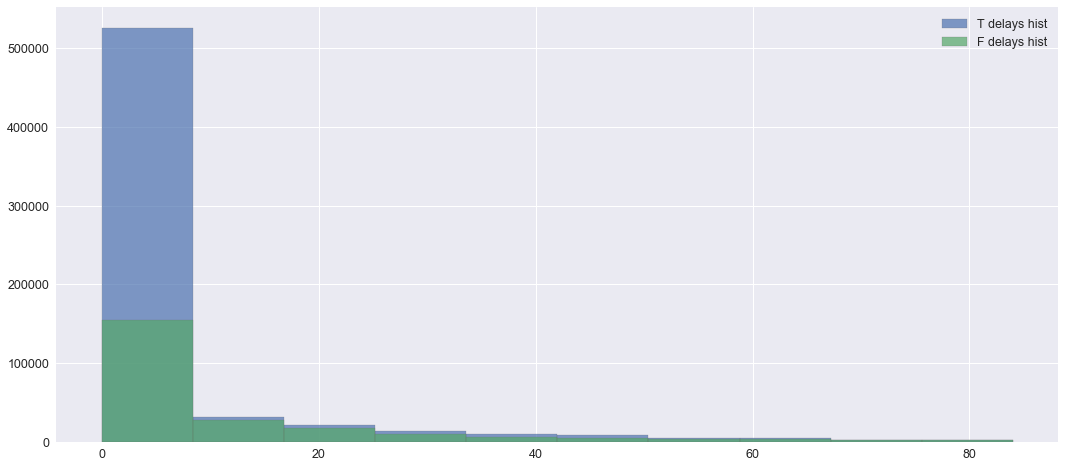

In [86]:
plt.figure(figsize=(16, 8))
tp_hist = plt.hist(y_delays[t.values], alpha=0.7, label='T delays hist')
fp_hist = plt.hist(y_delays[f.values], alpha=0.7, label='F delays hist')
plt.legend()

In [87]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [88]:
df1['YEAR_MONTH'] = df1.apply(lambda x: str(int(x.Year)) + '_' + str(int(x.Month)), axis=1)
year_month = np.unique(df1['YEAR_MONTH'])
for ym in year_month:
    print(ym)
    df2 = df1[df1.YEAR_MONTH == ym]
    df2.drop('YEAR_MONTH', axis=1, inplace=True)
    clf = RandomForestClassifier(n_estimators = 100, 
                                 max_depth = 3,
                                 n_jobs=-1, 
                                 class_weight='balanced')
    all_classifier(df2, target_col='START_DELAY_GREATER_5', to_scale=True, to_select=True, clf=clf)
    print()

2012_1


KeyError: 'START_DELAY_GREATER_5'

#### Try SVC

In [27]:
df1.columns

Index(['LEG_SEQUENCE_NUBMBER', 'IS_FROM_SVO', 'vis', 'temp', 'dewpt', 'press',
       'TIME_FROM_LAST_SCH_LAND', 'TIME_FROM_LAST_FACT_LAND',
       'LATE_ARRIVAL_BEFORE', 'START_DELAY_GREATER_5', 'FLIGHT_YEAR',
       'FLIGHT_MONTH', 'FLIGHT_DAY', 'FLIGHT_WEEKDAY', 'FLIGHT_YEAR_QUARTER',
       'FLIGHT_TIME_TO_MIDNIGHT', 'COUNT_PLANES_ON_SCH_TIME',
       'TAIL_NUMBER_START_DELAY_GREATER_5_ratio',
       'DISPLAY_CODE_START_DELAY_GREATER_5_ratio',
       'LEG_SEQUENCE_NUBMBER_START_DELAY_GREATER_5_ratio',
       'PUB_DEPARTURE_AIRPORT_CODE_PUB_ARRIVAL_AIRPORT_CODE_START_DELAY_GREATER_5_ratio',
       'iso_country_in_iso_country_out_START_DELAY_GREATER_5_ratio',
       'scheduled_service_in_scheduled_service_out_START_DELAY_GREATER_5_ratio',
       'type_closed_in_START_DELAY_GREATER_5_ratio',
       'type_large_airport_in_START_DELAY_GREATER_5_ratio',
       'type_medium_airport_in_START_DELAY_GREATER_5_ratio',
       'type_small_airport_in_START_DELAY_GREATER_5_ratio', 'YEAR_MONTH'],


In [28]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from time import time

In [29]:
#df1 = df1[df.FLIGHT_YEAR == 2016]
for ym in year_month:
    print(ym)
    df2 = df1[df1.YEAR_MONTH == ym]
    df2.drop('YEAR_MONTH', axis=1, inplace=True)
    clf = SVC(kernel='rbf', class_weight='balanced')
    all_classifier(df2, target_col='START_DELAY_GREATER_5', to_scale=True, to_select=True, clf=clf)
    print()

2013_10
classifier training time: 0.03 minutes
f1 score: 0.335
confusion matrix:
[[1004  120]
 [ 277  100]]

2013_11
classifier training time: 0.02 minutes
f1 score: 0.556
confusion matrix:
[[570 296]
 [225 326]]

2013_12
classifier training time: 0.02 minutes
f1 score: 0.499
confusion matrix:
[[694 291]
 [186 238]]

2013_8
classifier training time: 0.02 minutes
f1 score: 0.477
confusion matrix:
[[724 181]
 [257 200]]

2013_9
classifier training time: 0.03 minutes
f1 score: 0.570
confusion matrix:
[[565 292]
 [256 363]]

2014_1
classifier training time: 0.02 minutes
f1 score: 0.398
confusion matrix:
[[845 127]
 [309 144]]

2014_10
classifier training time: 0.03 minutes
f1 score: 0.282
confusion matrix:
[[1142  221]
 [ 172   77]]

2014_11
classifier training time: 0.03 minutes
f1 score: 0.228
confusion matrix:
[[1261   64]
 [ 193   38]]

2014_12
classifier training time: 0.03 minutes
f1 score: 0.476
confusion matrix:
[[903 133]
 [330 210]]

2014_2
classifier training time: 0.02 minutes


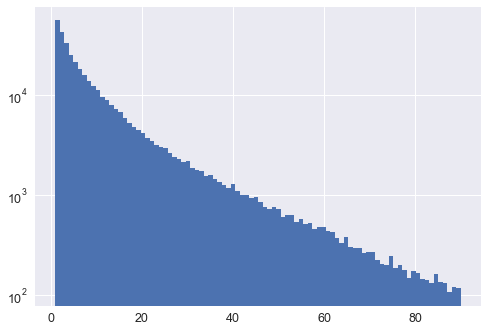

In [30]:
plt.hist(df['START_DELAY'][df.START_DELAY > 0], bins=90)
plt.yscale('log')

#### Try XGBoost

In [31]:
from time import time

start = time()
model = xgboost.XGBClassifier(n_estimators = 100, max_depth = 4)
model.fit(X_train, y_train)
print('classifier training time: %3.2f minutes' % ((time() - start) / 60))

classifier training time: 0.35 minutes


In [32]:
y_pred = est.predict(X_test)

print(f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.5449162838111463
[[30069 27291]
 [ 5298 19511]]


In [33]:
y_pred = est.predict(X_train)

print(f1_score(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

0.48172202020647914
[[191097  62647]
 [ 31280  43651]]


In [34]:
for ym in year_month:
    print(ym)
    df2 = df1[df1.YEAR_MONTH == ym]
    df2.drop('YEAR_MONTH', axis=1, inplace=True)
    clf = xgboost.XGBClassifier(n_estimators = 100, max_depth = 4)
    all_classifier(df2, target_col='START_DELAY_GREATER_5', to_scale=True, to_select=True, clf=clf)
    print()

2013_10
classifier training time: 0.01 minutes
f1 score: 0.139
confusion matrix:
[[1086   38]
 [ 346   31]]

2013_11
classifier training time: 0.01 minutes
f1 score: 0.130
confusion matrix:
[[843  23]
 [511  40]]

2013_12
classifier training time: 0.01 minutes
f1 score: 0.503
confusion matrix:
[[602 383]
 [153 271]]

2013_8
classifier training time: 0.01 minutes
f1 score: 0.291
confusion matrix:
[[810  95]
 [363  94]]

2013_9
classifier training time: 0.01 minutes
f1 score: 0.404
confusion matrix:
[[706 151]
 [424 195]]

2014_1
classifier training time: 0.00 minutes
f1 score: 0.318
confusion matrix:
[[881  91]
 [350 103]]

2014_10
classifier training time: 0.01 minutes
f1 score: 0.147
confusion matrix:
[[1323   40]
 [ 226   23]]

2014_11
classifier training time: 0.01 minutes
f1 score: 0.058
confusion matrix:
[[1320    5]
 [ 224    7]]

2014_12
classifier training time: 0.01 minutes
f1 score: 0.449
confusion matrix:
[[650 386]
 [272 268]]

2014_2
classifier training time: 0.01 minutes


**Gradient Boosting classifier**

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

start = time()
model = GradientBoostingClassifier(n_estimators = 100, max_depth = 4)
model.fit(X_train, y_train)
print('classifier training time: %3.2f minutes' % ((time() - start) / 60))

classifier training time: 1.50 minutes


In [36]:
y_pred = model.predict(X_test)

print(f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.5300603702040613
[[52707  4653]
 [14185 10624]]


In [37]:
y_pred = model.predict(X_train)

print(f1_score(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

0.4191222991238329
[[246218   7526]
 [ 53070  21861]]


In [38]:
#df1['YEAR_MONTH'] = df1.apply(lambda x: str(int(x.FLIGHT_YEAR)) + '_' + str(int(x.FLIGHT_MONTH)), axis=1)
year_month = np.unique(df1['YEAR_MONTH'])
for ym in year_month:
    print(ym)
    df2 = df1[df1.YEAR_MONTH == ym]
    df2.drop('YEAR_MONTH', axis=1, inplace=True)
    clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 4)
    all_classifier(df2, target_col='START_DELAY_GREATER_5', to_scale=True, to_select=True, clf=clf)
    print()

2013_10
classifier training time: 0.02 minutes
f1 score: 0.163
confusion matrix:
[[1018  106]
 [ 334   43]]

2013_11
classifier training time: 0.02 minutes
f1 score: 0.516
confusion matrix:
[[468 398]
 [221 330]]

2013_12
classifier training time: 0.02 minutes
f1 score: 0.499
confusion matrix:
[[675 310]
 [180 244]]

2013_8
classifier training time: 0.02 minutes
f1 score: 0.347
confusion matrix:
[[791 114]
 [337 120]]

2013_9
classifier training time: 0.02 minutes
f1 score: 0.442
confusion matrix:
[[636 221]
 [381 238]]

2014_1
classifier training time: 0.02 minutes
f1 score: 0.357
confusion matrix:
[[836 136]
 [325 128]]

2014_10
classifier training time: 0.02 minutes
f1 score: 0.208
confusion matrix:
[[1285   78]
 [ 211   38]]

2014_11
classifier training time: 0.02 minutes
f1 score: 0.201
confusion matrix:
[[1242   83]
 [ 196   35]]

2014_12
classifier training time: 0.02 minutes
f1 score: 0.468
confusion matrix:
[[584 452]
 [237 303]]

2014_2
classifier training time: 0.02 minutes


In [41]:
year = np.unique(df1['FLIGHT_YEAR'])
for y in year:
    print(y)
    df2 = df1[df1.FLIGHT_YEAR == y]
    df2.drop('YEAR_MONTH', axis=1, inplace=True)
    clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 4)
    all_classifier(df2, target_col='START_DELAY_GREATER_5', to_scale=True, to_select=True, clf=clf)
    print()

2013
classifier training time: 0.11 minutes
f1 score: 0.371
confusion matrix:
[[3710  622]
 [2046  786]]

2014
classifier training time: 0.36 minutes
f1 score: 0.288
confusion matrix:
[[13920   968]
 [ 2945   791]]

2015
classifier training time: 0.40 minutes
f1 score: 0.282
confusion matrix:
[[15011   988]
 [ 3845   951]]

2016
classifier training time: 0.44 minutes
f1 score: 0.292
confusion matrix:
[[12494  1345]
 [ 6459  1612]]

2017
classifier training time: 0.24 minutes
f1 score: 0.433
confusion matrix:
[[7179 1715]
 [2988 1795]]

